In [ ]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [35]:
import pandas as pd
import numpy as np
import importlib
importlib.reload(src.eda)
importlib.reload(src.stats_tests)
import src.eda
from src.eda import get_variable_types
from src.stats_tests import ttest, anova, plot_group_distributions

In [3]:
# load data
df = pd.read_csv("../data/df_cleaned.csv")

In [4]:
df.head()

,property_type,guest_capacity,location_score,review_score,amenities_count,host_response_time,season,cancellation_policy,nightly_rate,years_as_host_log,cleaning_fee_log,bedroom_encoded,min_stay_encoded
0,Standard Apartment,4,75.17,4.87,8,within an hour,peak,flexible,187.29,0.955511,3.110399,1,1
1,Standard Apartment,3,67.07,4.06,6,>24 hours,off-peak,flexible,255.64,1.629241,3.671225,1,1
2,Standard Apartment,2,76.57,4.16,10,same day,off-peak,flexible,62.82,1.193922,3.938470,0,0
3,Standard Apartment,2,88.14,3.74,11,same day,shoulder,strict,203.80,0.955511,3.593744,1,1
4,Luxury Home,4,58.63,3.37,15,same day,peak,strict,1000.00,0.641854,4.563306,2,3


In [10]:
num_cols, cat_cols = get_variable_types(df, "nightly_rate", 0) 
print(f'Numerical columns: {num_cols}')
print(f'Categorical columns: {cat_cols}')
target = df["nightly_rate"]

Numerical columns: ['guest_capacity', 'location_score', 'review_score', 'amenities_count', 'years_as_host_log', 'cleaning_fee_log', 'bedroom_encoded', 'min_stay_encoded']
Categorical columns: ['property_type', 'host_response_time', 'season', 'cancellation_policy']


In [11]:
for col in cat_cols:
    print(f"\n{col} (value counts):")
    print(df[col].value_counts(dropna=False))


property_type (value counts):
property_type
Standard Apartment    1945
Luxury Home           1186
Tiny Studio            737
Name: count, dtype: int64

host_response_time (value counts):
host_response_time
within an hour    1925
same day          1568
>24 hours          375
Name: count, dtype: int64

season (value counts):
season
peak        1558
shoulder    1156
off-peak    1154
Name: count, dtype: int64

cancellation_policy (value counts):
cancellation_policy
flexible    1939
moderate    1094
strict       835
Name: count, dtype: int64


### Features for Hypothesis test

Based on the EDA analysis result, I choose five tests to conduct:
1. property_type vs nightly_rate (ANOVA)
2. season vs nightly_rate (ANOVA)
3. guest_capacity vs nightly_rate (T-test with high/low capacity(>=4, room of 4 guest is common))
4. cleaning_fee vs nightly_rate (T-test with threshold 50)
5. cancellation_policy vs nightly_rate (ANOVA)


**Property_type vs nightly_rate**

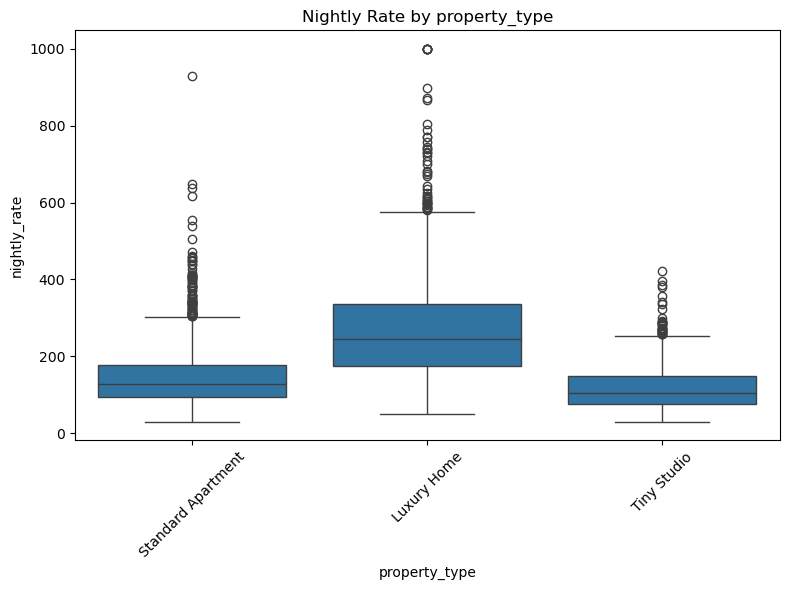

ANOVA: property_type
F-statistic: 793.12
P-value: 2.4447887211082434e-289


In [30]:
plot_group_distributions(df, "property_type")
anova(df, "property_type")

### Hypothesis Test: `property_type` vs `nightly_rate`

**Test Type:** ANOVA  
**Null Hypothesis (H₀):** The average nightly rate is the same across all property types.  
**Alternative Hypothesis (H₁):** At least one property type has a different average nightly rate.

**Test Result:**

- F-statistic = 793.12  
- p-value ≈ 2.44 × 10⁻²⁸⁹

**Statistical Significance:**  
We **reject the null hypothesis** with p < 0.05, concluding that the average nightly rates across different `property_type` groups are statistically significantly different.

**Practical Significance:**  
From the corresponding boxplot, it is evident that Luxury Homes charge substantially higher nightly rates compared to Standard Apartments and Tiny Studios. This difference is not only statistically significant but also practically meaningful: property type plays a critical role in Airbnb pricing strategy. Guests expect to pay more for larger, more premium accommodations, which is clearly reflected in the data.

**Conclusion:**  
This result supports the idea that `property_type` is a key price driver. It should be carefully considered in predictive modeling and pricing policy.

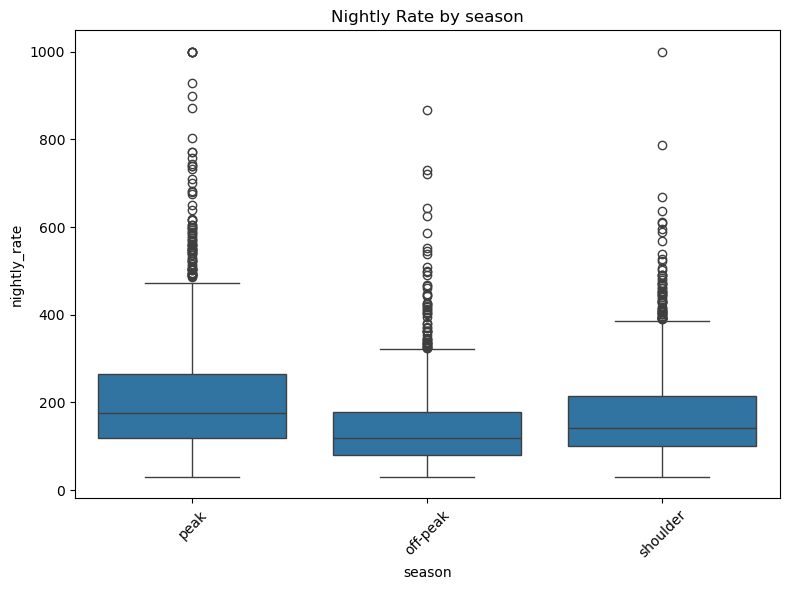

ANOVA: season
F-statistic: 119.17
P-value: 5.987131784728386e-51


In [31]:
plot_group_distributions(df, "season")
anova(df, "season")

### Hypothesis Test: `season` vs `nightly_rate`

**Test Type:** ANOVA  
**Null Hypothesis (H₀):** The average nightly rate is the same across all seasons.  
**Alternative Hypothesis (H₁):** At least one season has a different average nightly rate.

**Test Result:**

- F-statistic = 119.17  
- p-value ≈ 5.99 × 10⁻⁵¹

**Statistical Significance:**  
We **reject the null hypothesis** with p < 0.05 and conclude that seasonal variation significantly affects nightly rate.

**Practical Significance:**  
As seen in the boxplot, `peak` seasons clearly have a higher median and wider price range than `shoulder` or `off-peak` seasons. This demonstrates that Airbnb hosts adjust pricing based on seasonal demand, which is both statistically and practically significant.

**Conclusion:**  
Seasonality is a strong predictor of price fluctuations and should be included in predictive models or pricing strategies.

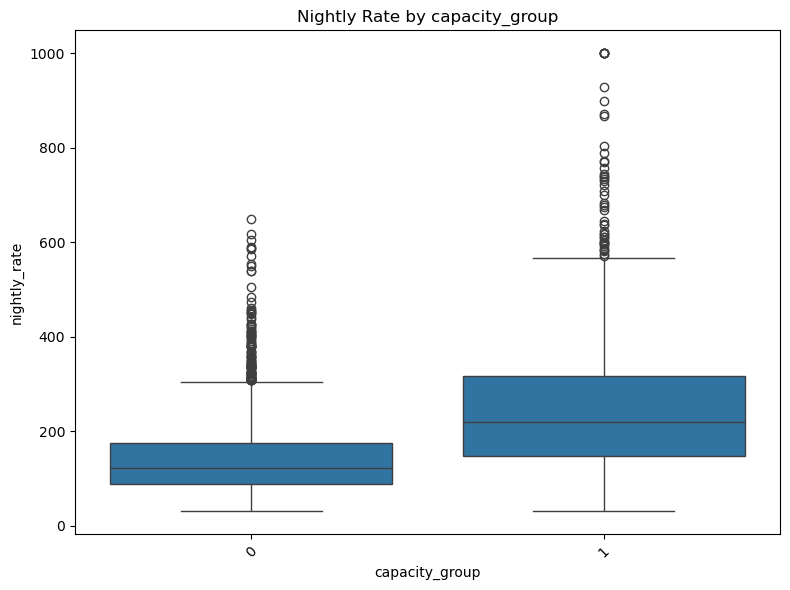

T-test:
T-statistic: 25.55
P-value: 1.0302092129242896e-123


In [36]:
df["capacity_group"] = (df["guest_capacity"] >= 4).astype(int)

high_capacity = df[df["capacity_group"] == 1]["nightly_rate"]
low_capacity = df[df["capacity_group"] == 0]["nightly_rate"]

plot_group_distributions(df, "capacity_group")
ttest(df, high_capacity, low_capacity)

### Hypothesis Test: `guest_capacity` vs `nightly_rate`

**Test Type:** Independent T-test  
**Grouping Method:** Two groups were formed based on guest capacity:
- Group 0: Capacity < 4  
- Group 1: Capacity ≥ 4

**Null Hypothesis (H₀):** There is no difference in average nightly rate between low and high guest capacity listings.  
**Alternative Hypothesis (H₁):** There is difference in average nightly rate between low and high guest capacity listings.

**Test Result:**

- T-statistic = 25.55  
- p-value ≈ 1.03 × 10⁻¹²³

**Statistical Significance:**  
We **reject H₀** with p < 0.05, concluding that guest capacity significantly affects the nightly rate.

**Practical Significance:**  
The boxplot shows that listings with a capacity of 4 or more guests tend to have much higher nightly rates. This is reasonable, as larger listings offer more space and tend to serve larger groups or families, justifying higher prices.

**Conclusion:**  
Guest capacity is an important factor in Airbnb pricing and should be retained in predictive modeling.

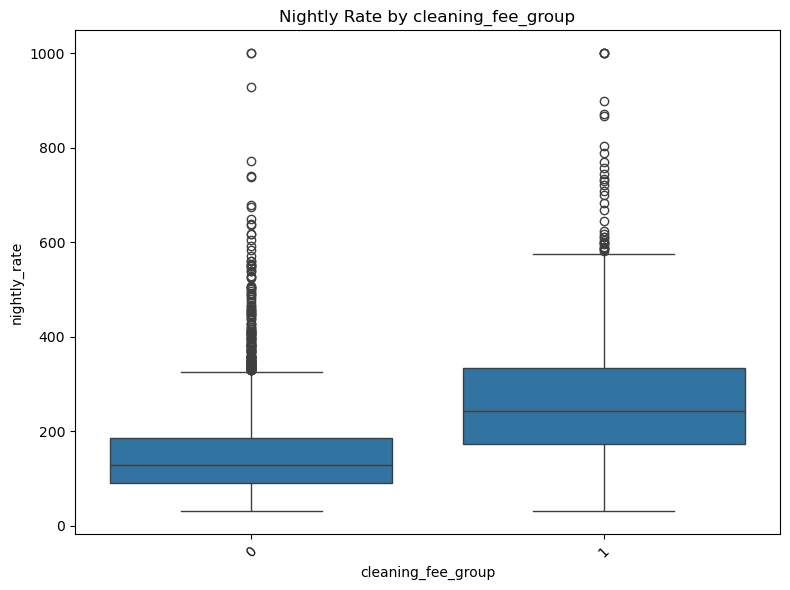

T-test:
T-statistic: 23.47
P-value: 3.4629450456608207e-100


In [37]:
df["cleaning_fee_group"] = (df["cleaning_fee_log"] >= np.log1p(50)).astype(int)

high_fee = df[df["cleaning_fee_group"] == 1]["nightly_rate"]
low_fee = df[df["cleaning_fee_group"] == 0]["nightly_rate"]

plot_group_distributions(df, "cleaning_fee_group")
ttest(df, high_fee, low_fee)

### Hypothesis Test: `cleaning_fee` vs `nightly_rate`

**Test Type:** Independent T-test  
**Grouping Method:** Two groups based on log-transformed cleaning fee:
- Group 0: Cleaning fee ≤ 50  
- Group 1: Cleaning fee > 50

**Null Hypothesis (H₀):** There is no difference in average nightly rate between listings with lower vs. higher cleaning fees.  
**Alternative Hypothesis (H₁):** There is difference in average nightly rate between listings with lower vs. higher cleaning fees.

**Test Result:**

- T-statistic = 23.47  
- p-value ≈ 3.46 × 10⁻¹⁰⁰

**Statistical Significance:**  
We **reject H₀** with p < 0.05, suggesting a significant relationship between cleaning fees and nightly rates.

**Practical Significance:**  
As seen in the boxplot, listings with higher cleaning fees tend to charge noticeably more per night. This aligns with expectations, as higher cleaning fees are often associated with larger or more luxurious properties, which also command higher base rates.

 **Conclusion:**  
Cleaning fee is a strong indicator of nightly rate pricing and should be considered in pricing models.

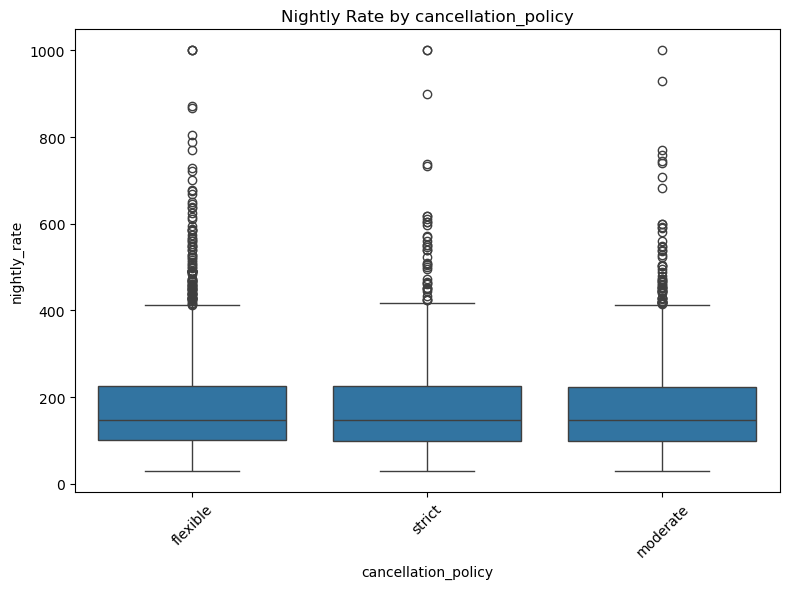

ANOVA: cancellation_policy
F-statistic: 0.19
P-value: 0.8305748290780368


In [39]:
plot_group_distributions(df, "cancellation_policy")
anova(df, "cancellation_policy")

### Hypothesis Test: `cancellation_policy` vs `nightly_rate`

**Test Type:** ANOVA  
**Grouping Variable:** Cancellation Policy  
- Categories: Flexible, Moderate, Strict

**Null Hypothesis (H₀):** The mean nightly rate is the same across all cancellation policy types.  
**Alternative Hypothesis (H₁):** At least one cancellation policy category has a different mean nightly rate.

**Test Result:**

- F-statistic = 0.19  
- p-value = 0.831

**Statistical Significance:**  
The p-value is larger than the threshold 0.05, indicating no statistically significant difference between groups. Therefore, we **fail to reject the null hypothesis**.

**Practical Significance:**  
As supported by the boxplot, the distributions of nightly rates appear nearly identical across all cancellation policies. This suggests that cancellation flexibility is not a key driver of price variation in this dataset.

**Conclusion:**  
Cancellation policy has **no statistically or practically significant** relationship with nightly rate.